# Chest X-ray disease progression

## Dataset

192 images scored with the Brixia score:

1. https://github.com/BrixIA/Brixia-score-COVID-19
2. https://arxiv.org/abs/2006.04603

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import tqdm
import pandas as pd
import torchxrayvision as xrv

/opt/anaconda3/envs/deepflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [49]:
# Base is Brixia-score-COVID-19 repository
base = './Brixia-score-COVID-19-master/'
covid_19_metadata = './covid-chestxray-dataset-master/metadata.csv'


df_metadata = pd.read_csv(covid_19_metadata)
df_annotations = pd.read_csv(base + 'data/public-annotations.csv')
df_metadata_partial = df_metadata[df_metadata.filename.isin(list(df_annotations.filename))]
df_metadata_partial = df_metadata_partial.reset_index(drop=True)
df_metadata_partial.to_csv("metadata_192_images.csv")

In [36]:
d_covid19 = xrv.datasets.COVID19_Dataset(imgpath= base + 'data/public-cohen-subset', csvpath="metadata_192_images.csv")
d_covid19

In [38]:
xrv.datasets.relabel_dataset(xrv.datasets.default_pathologies, d_covid19)

{'COVID-19', 'Chlamydophila', 'Viral', 'Bacterial', 'Pneumocystis', 'Legionella', 'No Finding', 'Klebsiella', 'SARS', 'Streptococcus', 'Fungal'} will be dropped
Atelectasis doesn't exist. Adding nans instead.
Consolidation doesn't exist. Adding nans instead.
Infiltration doesn't exist. Adding nans instead.
Pneumothorax doesn't exist. Adding nans instead.
Edema doesn't exist. Adding nans instead.
Emphysema doesn't exist. Adding nans instead.
Fibrosis doesn't exist. Adding nans instead.
Effusion doesn't exist. Adding nans instead.
Pleural_Thickening doesn't exist. Adding nans instead.
Cardiomegaly doesn't exist. Adding nans instead.
Nodule doesn't exist. Adding nans instead.
Mass doesn't exist. Adding nans instead.
Hernia doesn't exist. Adding nans instead.
Lung Lesion doesn't exist. Adding nans instead.
Fracture doesn't exist. Adding nans instead.
Lung Opacity doesn't exist. Adding nans instead.
Enlarged Cardiomediastinum doesn't exist. Adding nans instead.


{'Atelectasis': nan,
 'Consolidation': nan,
 'Infiltration': nan,
 'Pneumothorax': nan,
 'Edema': nan,
 'Emphysema': nan,
 'Fibrosis': nan,
 'Effusion': nan,
 'Pneumonia': 1.0,
 'Pleural_Thickening': nan,
 'Cardiomegaly': nan,
 'Nodule': nan,
 'Mass': nan,
 'Hernia': nan,
 'Lung Lesion': nan,
 'Fracture': nan,
 'Lung Opacity': nan,
 'Enlarged Cardiomediastinum': nan}

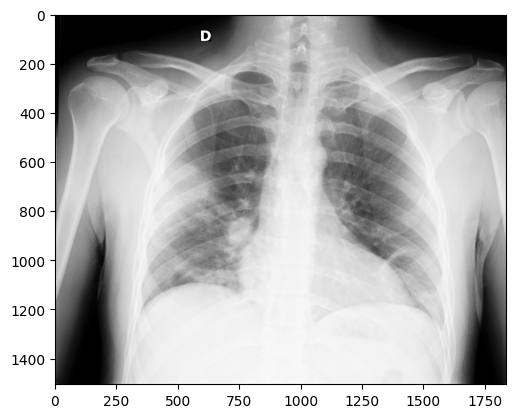

In [39]:
sample = d_covid19[40]
plt.imshow(sample["img"][0], cmap="Greys_r");
dict(zip(d_covid19.pathologies, sample["lab"]))

In [40]:
model = xrv.models.DenseNet(weights="densenet121-res224-all")

In [41]:
# does the model align with the dataset?
dict(zip(model.pathologies,xrv.datasets.default_pathologies))

{'Atelectasis': 'Atelectasis',
 'Consolidation': 'Consolidation',
 'Infiltration': 'Infiltration',
 'Pneumothorax': 'Pneumothorax',
 'Edema': 'Edema',
 'Emphysema': 'Emphysema',
 'Fibrosis': 'Fibrosis',
 'Effusion': 'Effusion',
 'Pneumonia': 'Pneumonia',
 'Pleural_Thickening': 'Pleural_Thickening',
 'Cardiomegaly': 'Cardiomegaly',
 'Nodule': 'Nodule',
 'Mass': 'Mass',
 'Hernia': 'Hernia',
 'Lung Lesion': 'Lung Lesion',
 'Fracture': 'Fracture',
 'Lung Opacity': 'Lung Opacity',
 'Enlarged Cardiomediastinum': 'Enlarged Cardiomediastinum'}

In [42]:
# Check the model output for the first image
model = xrv.models.DenseNet(weights="all")
with torch.no_grad():
    out = model(torch.from_numpy(sample["img"]).unsqueeze(0)).cpu()
    
dict(zip(model.pathologies,zip(out[0].detach().numpy(), sample["lab"])))

{'Atelectasis': (0.5132021, nan),
 'Consolidation': (0.52594936, nan),
 'Infiltration': (0.5910032, nan),
 'Pneumothorax': (0.505182, nan),
 'Edema': (0.50121814, nan),
 'Emphysema': (0.50456595, nan),
 'Fibrosis': (0.52441144, nan),
 'Effusion': (0.1849742, nan),
 'Pneumonia': (0.61142063, 1.0),
 'Pleural_Thickening': (0.50173223, nan),
 'Cardiomegaly': (0.50059307, nan),
 'Nodule': (0.59731615, nan),
 'Mass': (0.5839808, nan),
 'Hernia': (0.033548404, nan),
 'Lung Lesion': (0.20972906, nan),
 'Fracture': (0.51450455, nan),
 'Lung Opacity': (0.59629506, nan),
 'Enlarged Cardiomediastinum': (0.5078892, nan)}

In [43]:
tr = xrv.datasets.XRayResizer(224)
data_transforms = torchvision.transforms.Compose([
        xrv.datasets.ToPILImage(),
        torchvision.transforms.RandomAffine(45, translate=(0.15, 0.15), scale=(0.85, 1.15)),
        torchvision.transforms.ToTensor(),
    ])

In [44]:
model = xrv.models.DenseNet(weights="all")
if torch.cuda.is_available():
    model = model.cuda()


with torch.no_grad():
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(d_covid19))):
        sample = d_covid19[i]
    
        image = data_transforms(tr(sample["img"])).unsqueeze(0)
        features = model.features(image)
        if torch.cuda.is_available():
            image = image.cuda()
        
        features = model.features(image).cpu()
        features = pd.DataFrame(features.numpy().flatten().reshape(1,-1))
        
        filename = df_metadata_partial.loc[sample['idx'], 'filename']
        
        if i == 0:
            embeddings = features
            filenames = [filename]
        else:
            embeddings = pd.concat((embeddings, features), axis=0, ignore_index=True)
            filenames.append(filename)

100%|██████████| 256/256 [02:50<00:00,  1.51it/s]


In [45]:
filenames=pd.DataFrame(filenames, columns=['filename'])
embeddings.to_csv(f"embeddings.csv", sep=",", header=False)
filenames.to_csv(f"filenames.csv", sep=",")
print("Prediction completed, outputs dumped!")